In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)



In [69]:
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [70]:
# load  dataset
df = pd.read_csv('/home/francovm/Projects/SSE/data/processed/input_data.csv', sep='\t', encoding='utf-8')


In [71]:
df.head()

,x,n,u,Events
0,-12.28,-92.30,-9.23,0.0
1,-12.58,-92.54,-11.31,0.0
2,-13.16,-92.24,-8.02,0.0
3,-13.21,-92.20,-11.51,0.0
4,-12.92,-93.19,-10.20,0.0


In [72]:
input_X = df.loc[:, df.columns != 'Events'].values  # converts the df to a numpy array
input_y = df['Events'].values

n_features = input_X.shape[1]  # number of features

print(input_X.shape,input_y.shape)

(229716, 3) (229716,)


In [73]:
def temporalize(X, y, lookback):
    X = []
    y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+lookback+1])
    return X, y


In [74]:
# Temporalize the data
lookback = 5
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)



In [75]:
#Split into Test, valid and train

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [76]:
# Reshape the arrays

X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
# X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
# X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
# X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
# X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)b
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

In [77]:
y_train.shape

(147014,)

In [78]:
## To Categorical Data

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# y_valid = to_categorical(y_valid)

# print(y_valid.shape, y_test.shape, y_train.shape)

In [79]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1
print(n_timesteps,n_features,n_outputs)

5 3 1


In [80]:
# fit and evaluate a model
def evaluate_model(X_train, y_train, X_test, y_test):
    
    verbose, epochs, batch_size = 1, 15, 64
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
#     model.add(Dense(n_outputs, activation='softmax'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # fit network
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size ,validation_data=(X_valid, y_valid),verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    
    return accuracy

In [81]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


In [82]:
# run an experiment
def run_experiment(repeats=2):
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(X_train, y_train, X_test, y_test)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)
 
    # run the experiment
# run_experiment()

# Prediction


In [83]:
# Parameters

verbose, epochs, batch_size = 1, 100, 64



model = Sequential()
model.add(LSTM(50, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
#     model.add(Dense(n_outputs, activation='softmax'))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=5)

# fit network
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_valid, y_valid), verbose=verbose,
                    callbacks=[early_stopping_monitor])


# evaluate model
accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)

Train on 147014 samples, validate on 36754 samples
Epoch 1/100
147014/147014 [==============================] - 60s 406us/step - loss: 0.1844 - acc: 0.9543 - val_loss: 0.1745 - val_acc: 0.9574
Epoch 2/100
147014/147014 [==============================] - 57s 389us/step - loss: 0.1729 - acc: 0.9571 - val_loss: 0.1705 - val_acc: 0.9574
Epoch 3/100
147014/147014 [==============================] - 57s 387us/step - loss: 0.1714 - acc: 0.9571 - val_loss: 0.1738 - val_acc: 0.9574
Epoch 4/100
147014/147014 [==============================] - 57s 385us/step - loss: 0.1705 - acc: 0.9571 - val_loss: 0.1679 - val_acc: 0.9574
Epoch 5/100
147014/147014 [==============================] - 57s 390us/step - loss: 0.1699 - acc: 0.9571 - val_loss: 0.1685 - val_acc: 0.9574
Epoch 6/100
147014/147014 [==============================] - 57s 389us/step - loss: 0.1694 - acc: 0.9571 - val_loss: 0.1690 - val_acc: 0.9574
Epoch 7/100
147014/147014 [==============================] - 57s 389us/step - loss: 0.1688 - acc:

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


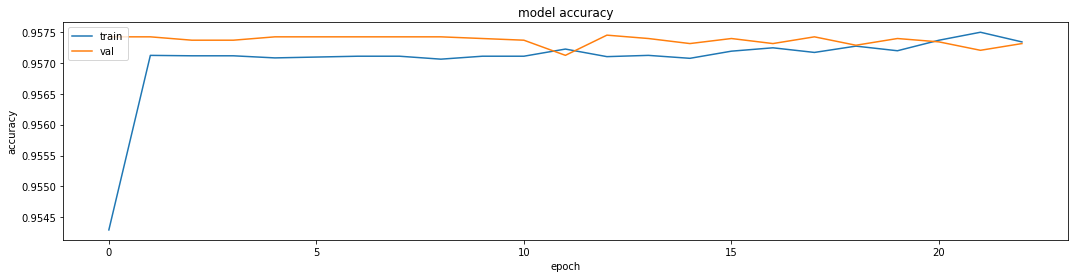

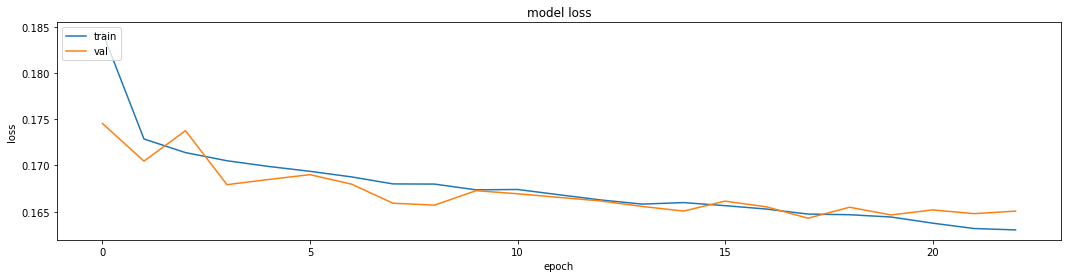

In [86]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# Get current size
fig_size = plt.rcParams["figure.figsize"]
#  Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

plt.savefig('/home/francovm/Projects/SSE/data/Visualization/LSTM-5days-acc.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
 # Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

plt.savefig('/home/francovm/Projects/SSE/data/Visualization/LSTM-5days-loss.png')
plt.show()

In [87]:
# save model and architecture to single file
model.save("/home/francovm/Projects/SSE/models/Binary_clasifier/Binary_clasifier_LSTM_SSE_5days.h5")

In [34]:
# ynew = model.predict(X_test)

In [2]:
# ynew

In [1]:
# plt.plot(ynew) # plotting by columns
# plt.axhline(0.5)
# plt.show()